<h1><center>Understanding Pitchfork Album Reviews</center></h1>
<center><h3>By Avani Amin, Adam Bourn, Allie Maurer, and Daniel Merchant</h3></center>

# Overview
The online music magazine Pitchfork describes itself as "the most trusted voice in music". But how trustworthy is it really? Or, in other words, is the site biased? In this project we attempt to figure this out by examining these questions:
- How do reviews for genres change over time?
- Is there a correlation between an album's score and it being in Pitchfork's Best New Music?
- Is there a correlation between genre and review score?
- Is there a correlation between genre and selection for Best New Music?

The data we will use was retrieved from a database containing over 18,000 reviews from the online music magazine “Pitchfork”. This data was collected by Nolan Conaway and made publicly accessible via Kaggle. 

(note: click the 'Show Code' button in the top left corner to reveal the code)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import statsmodels.formula.api as smf
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [13]:
# Load in data
data = pd.read_csv('data/p4kreviews.csv', encoding='latin1', index_col=[0])

Let's look at the structure of the data:

In [14]:
data.head()

,album,artist,best,date,genre,review,score
1,A.M./Being There,Wilco,1,December 6 2017,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0
2,No Shame,Hopsin,0,December 6 2017,Rap,"On his corrosive fifth album, the rapper takes...",3.5
3,Material Control,Glassjaw,0,December 6 2017,Rock,"On their first album in 15 years, the Long Isl...",6.6
4,Weighing of the Heart,Nabihah Iqbal,0,December 6 2017,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7
5,The Visitor,Neil Young / Promise of the Real,0,December 5 2017,Rock,"While still pointedly political, Neil Youngs ...",6.7


A few things to note:
- The data stores information about the album being reviewed as well as the review itself
- 'best' stores a binary value indicating if the album being reviewed was selected for Pitchfork's best new music. Pitchfork's Best New Music is a curated list of albums that Pitchfork has selected to feature as especially worth listening to
- 'review' is the score given to the album ranked from 1-10

# Data Prep
In this section, we will describe the prep we performed on the data for easier analysis. The following are the steps we took to wrangle the data:

- For later convenience, we created a grouped object where all reviews by a particular artist are groupped together.

In [15]:
grouped_by_artist = data.groupby(['artist'])

- Looking at our dataset, we see that there are ~800 reviews for "Various Artists".  At the time of analysis of artist statistics, "Various Artists" doesn't provide much insight as we do not know the specific artist.  Thus, we created a separate dataframe that removed rows where the artist is "Various Artists".

In [16]:
reviews_no_various_artists = data[data.artist != "Various Artists"]

- The dataset stored the date as straight text. We converted this to be a proper date type for later use.

In [17]:
# Convert date column to date values
data['date'] = pd.to_datetime(data['date'])
reviews_no_various_artists['date'] = pd.to_datetime(reviews_no_various_artists['date'])

/Users/Avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


- For convenience sake, we altered the review scores to be out of 100 so it is easier to visualize the score given to an album.  Thus, we multiplied the scores by 10.

In [18]:
data["score_of_100"] = pd.to_numeric(data["score"]*10, downcast='integer')
reviews_no_various_artists["score_of_100"] = pd.to_numeric(reviews_no_various_artists["score"]*10, downcast='integer')

/Users/Avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Exploration
In this section, we will examine the data a little more closely.

In order to get a basic understanding of the review scores, we have calculated the mean score out of all reviews from the data (including various artists reviews). This gives us a basic understanding of how high/low Pitchfork reviewers score. The average score of all reviews is 7.027.

In [19]:
# Calculate the mean score for all reviews -- including "Various Artists"
mean_score = np.mean(data["score"])
print("Calculated average score: %f" % (mean_score))

Calculated average score: 7.027446


To further examine the scores Pitchfork reviewers give, we have broken down the average scores by genre. This not only gives us a baseline for scores of the various genres but also gives us a preliminary examination of the reviewers' preferences. Based solely on the average review score, Jazz music recieves the highest scores (average of 7.568) and Electronic music recieves the lowest scores (average of 6.941). Keep in mind, this table solely shows averages so it does not factor in how many reviews are in each genre.

In [20]:
# Calculate the average scores for each genre.
groupped_by_genre = data.groupby(by="genre").agg(np.mean)
groupped_by_genre['score']

genre
Electronic      6.941318
Experimental    7.359035
Folk/Country    7.219857
Global          7.434831
Jazz            7.568482
Metal           6.980410
None            7.020611
Pop/R&B         6.948315
Rap             6.950304
Rock            6.983616
Name: score, dtype: float64

Although we can compare averages between genres, the amount of reviews per genre could greatly skew these average scores. Because of this, we have chosen to also examine the number of reviews for each genre. So, although jazz has the highest average score, there are only 257 reviews. This is extremely low compared to some of the other genres, such as Rock which has 6958 reviews.

In [21]:
# number of reviews in genre
review_count = data.groupby('genre').size().reset_index(name='count')
review_count

,genre,count
0,Electronic,4020
1,Experimental,1699
2,Folk/Country,700
3,Global,178
4,Jazz,257
5,Metal,781
6,None,2324
7,Pop/R&B,1157
8,Rap,1481
9,Rock,6958


Here, we show the ratios of the amount of reviews that are in best new music compared to total reviews, broken down by genre. In other words, for each genre, we have calculated the percentage of reviews that were chosen for Best New Music. We see that Jazz has the highest percentage (9.727%) and None (no categorized genre) has the worst percentage (2.367%).

In [22]:
# Find ratios of best new music to number of reviews in genre
best_new_music = data[data["best"] == 1]
best_new_music_by_genre = data.groupby(['genre']).agg(['mean']) # 'Best' is either 1 or 0, so we can just average the best column
bnm_ratios = best_new_music_by_genre['best']
bnm_ratios

,mean
genre,
Electronic,0.048010
Experimental,0.065333
Folk/Country,0.047143
Global,0.050562
Jazz,0.097276
Metal,0.028169
None,0.023666
Pop/R&B,0.075194
Rap,0.055368


# Visualizations

## Number of Reviews Per Year
As part of our exploration, we wanted to find out how many reviews Pitchfork releases per year. We did this to get a sense of the volume of reviews that are put out per year, and explore if the volume of reviews is inconsistent over time. After performing this visualization, we found that from 1999 to 2003, Pitchfork experienced growth in the number of reviews released per year. From 2004 onward, the number of reviews released by Pitchfork remains relatively constant. From this, we have a better understanding of the growth of the magazine. Also, understanding the volume of transactions can help us understand potential discrepancies when we look at data broken down by year since earlier years have a smaller volume of reviews comparative to later years.

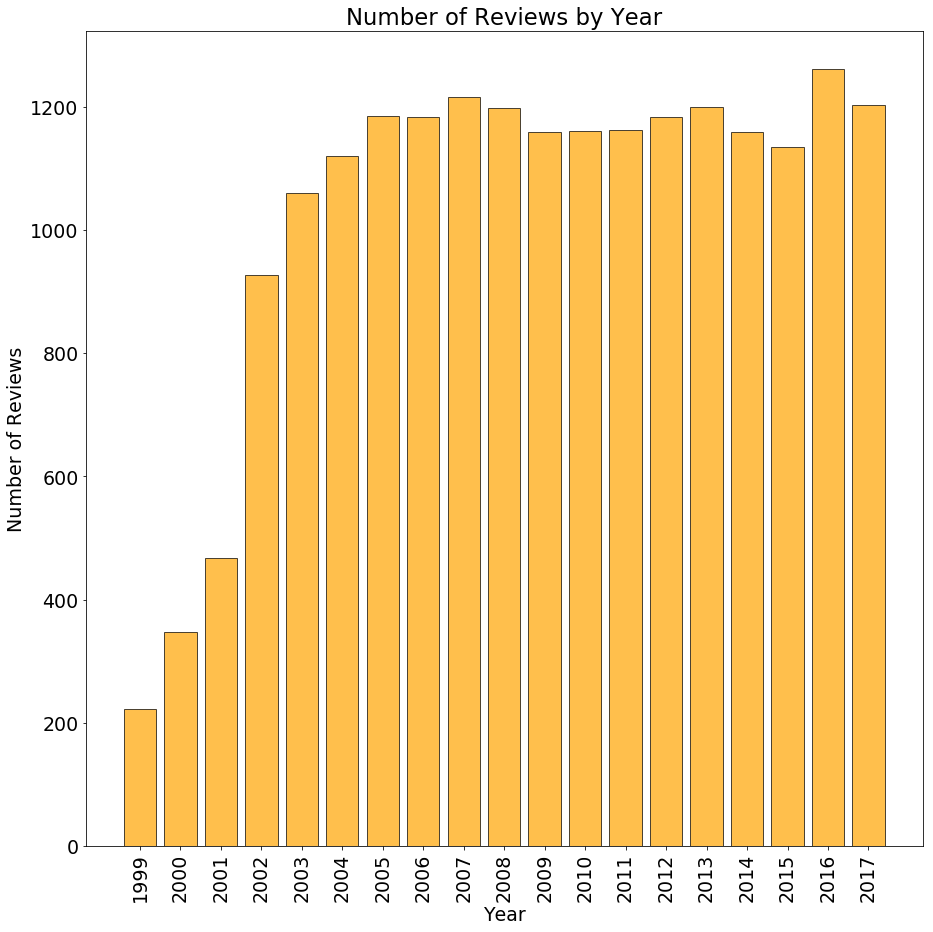

In [23]:
# num reviews per year
reviews_by_year = data[['review']].groupby(data['date'].dt.year).count()
plt.figure(figsize=(15, 15))
plt.rcParams.update({'font.size': 19})
plt.bar(reviews_by_year.index, reviews_by_year['review'], color='orange', alpha=0.7, edgecolor='black')
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## Number of Reviews Per Genre
As part of our initial exploration, we also wanted to explore the number of reviews per genre. We chose to perform this exploration to see if there were genres that Pitchfork tends to review over others. This could indicate a preference, which could potentially indicate a bias. From this exploration, we found that Pitchfork tends to review Rock music more than any other genre, having more ~3000 more reviews than the next most reviewed genre. This indicates that the magazine potentially has a preference for this music genre, which could lead to a bias in their reviews of Rock music.

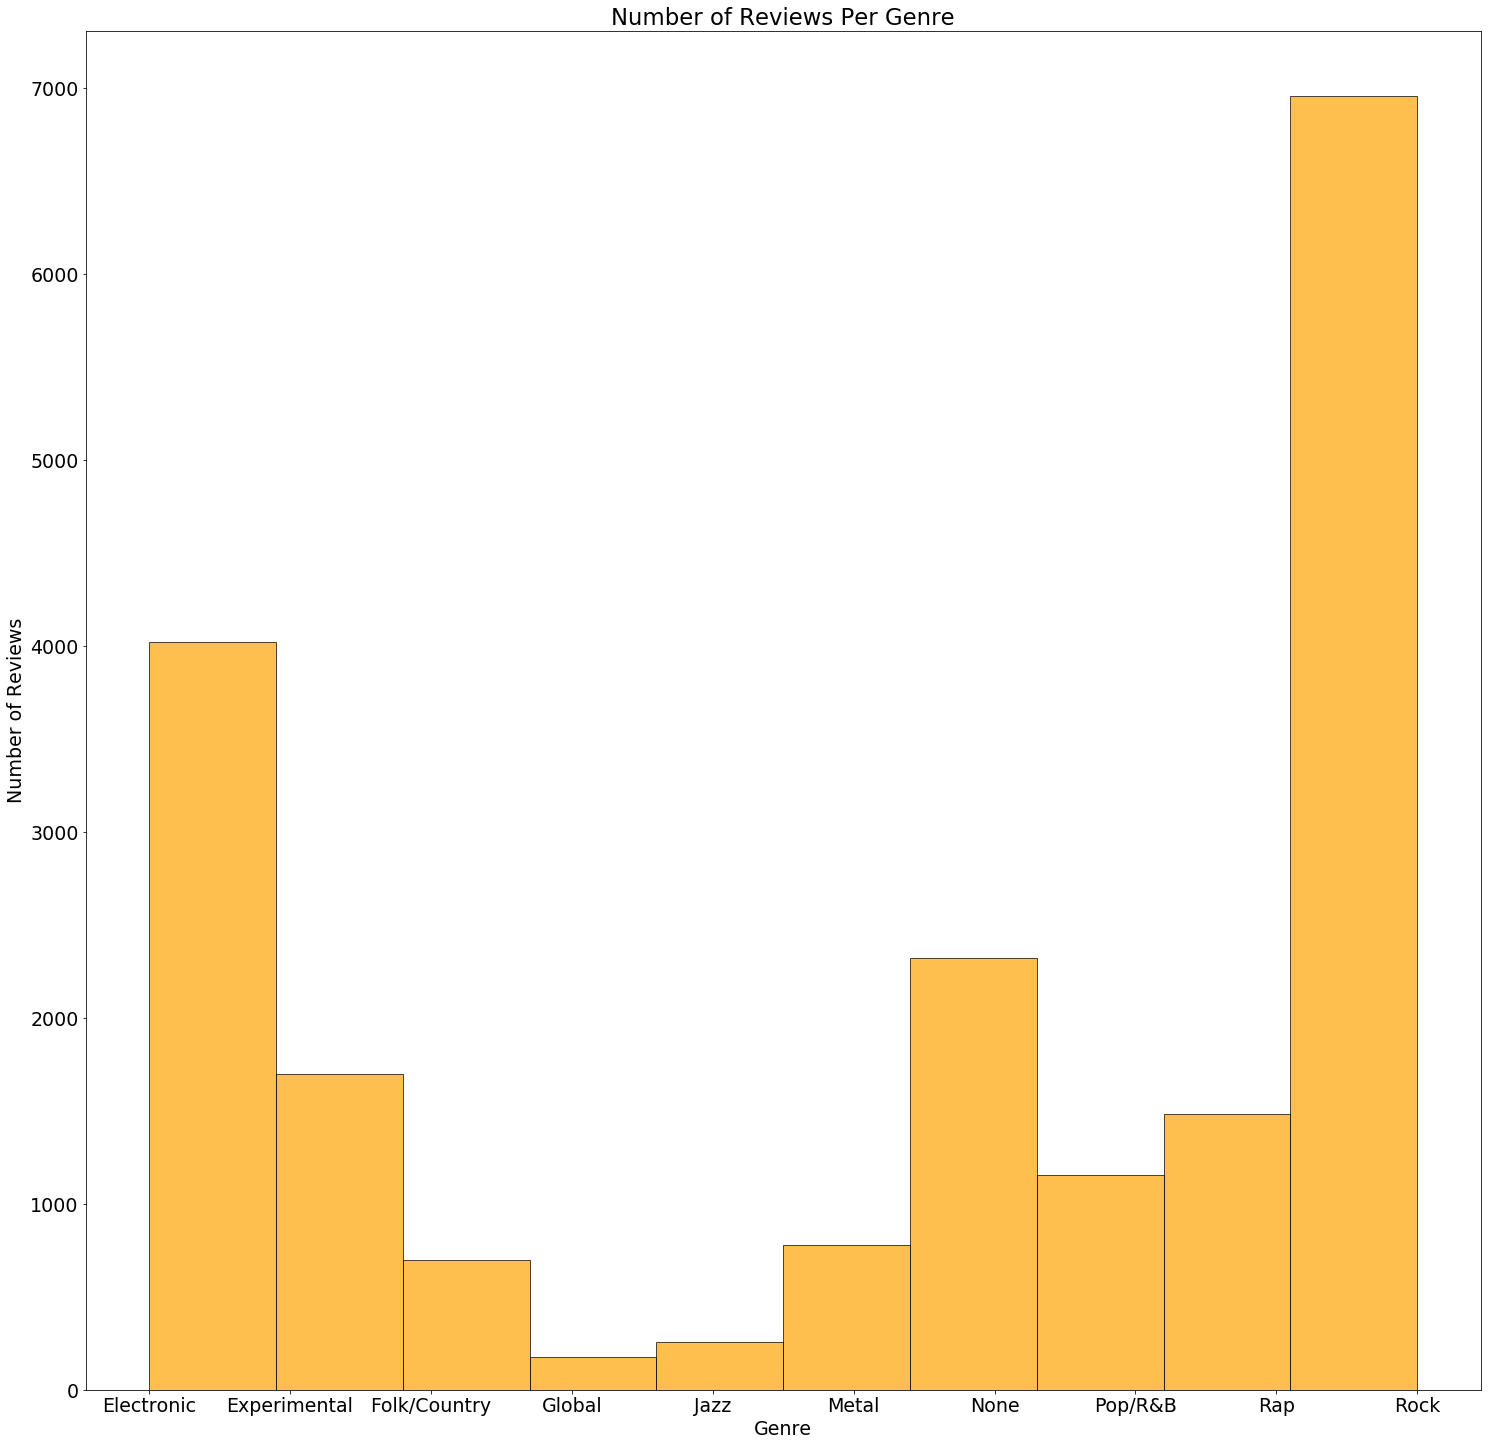

In [24]:
# number of reviews per genre
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.hist(data['genre'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Number of Reviews Per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Reviews")
plt.show()

## Distribution of Scores
The next step we took in our initial exploration was to understand the distribution of scores. We thought this would be a useful exploration so we would have a better understanding of the most common review score. Since review scores can contain decimals (ex: 7.6/10), we converted the scores to be out of 100, as discussed in the Data Prep section. From this exploration, we see a right-shift in our data. This shows us that Pitchfork is more likely to give a higher score than a lower score. We also see that the data peaks around the 70s, so we can see that most reviews are about 7 points out of 10.

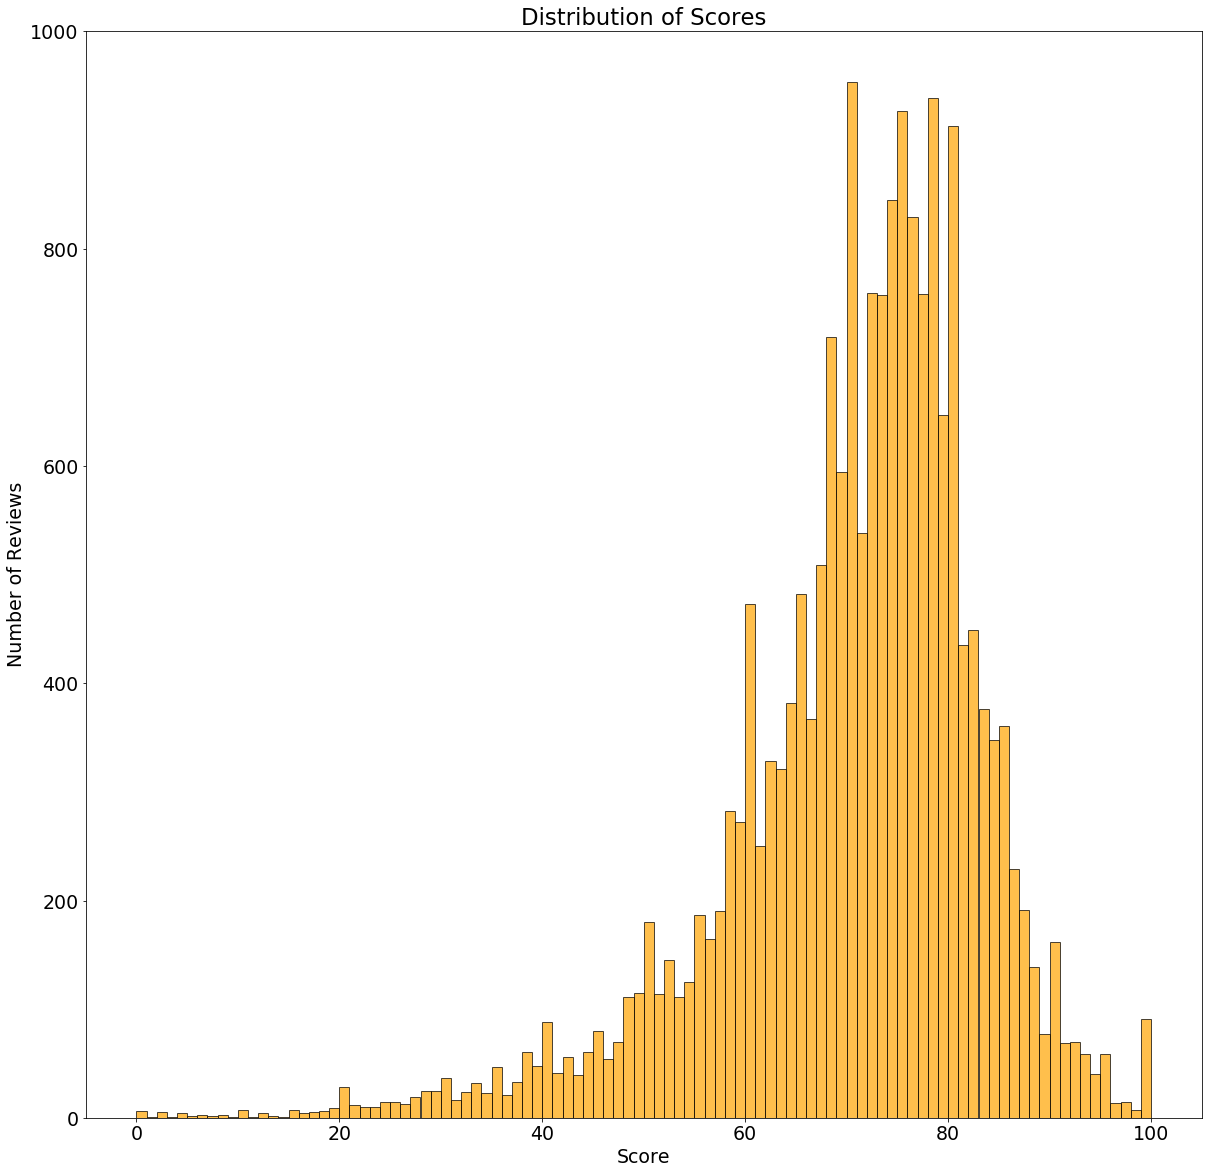

In [25]:
# Distribution of scores
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 19})
plt.hist(data['score_of_100'], bins=100, color='orange', alpha=0.7, edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.show()

## Word Count
Something we thought could be interesting to explore would be the word counts of reviews. We were thinking about exploring review word count in relation to review scores and genre to see if there is a correlation between these factors, and felt that a good first step to take before performing any type of regression would be to understand common review article lengths. From performing this exploration, we found that the most common article length was between ~400-800 words. We also found that there were a couple of outlier articles that had a word count ranging from ~2500 to 3800. These outliers have the potential to skew any model we create, so it is important to keep this in mind when we run a regression.

In [26]:
# Count the words in the reviews -- takes a long time
count_array = []
for i in data.index:
    count = len(nltk.word_tokenize(str(data["review"][i])))
    count_array.append(count)
data["review_word_count"] = count_array

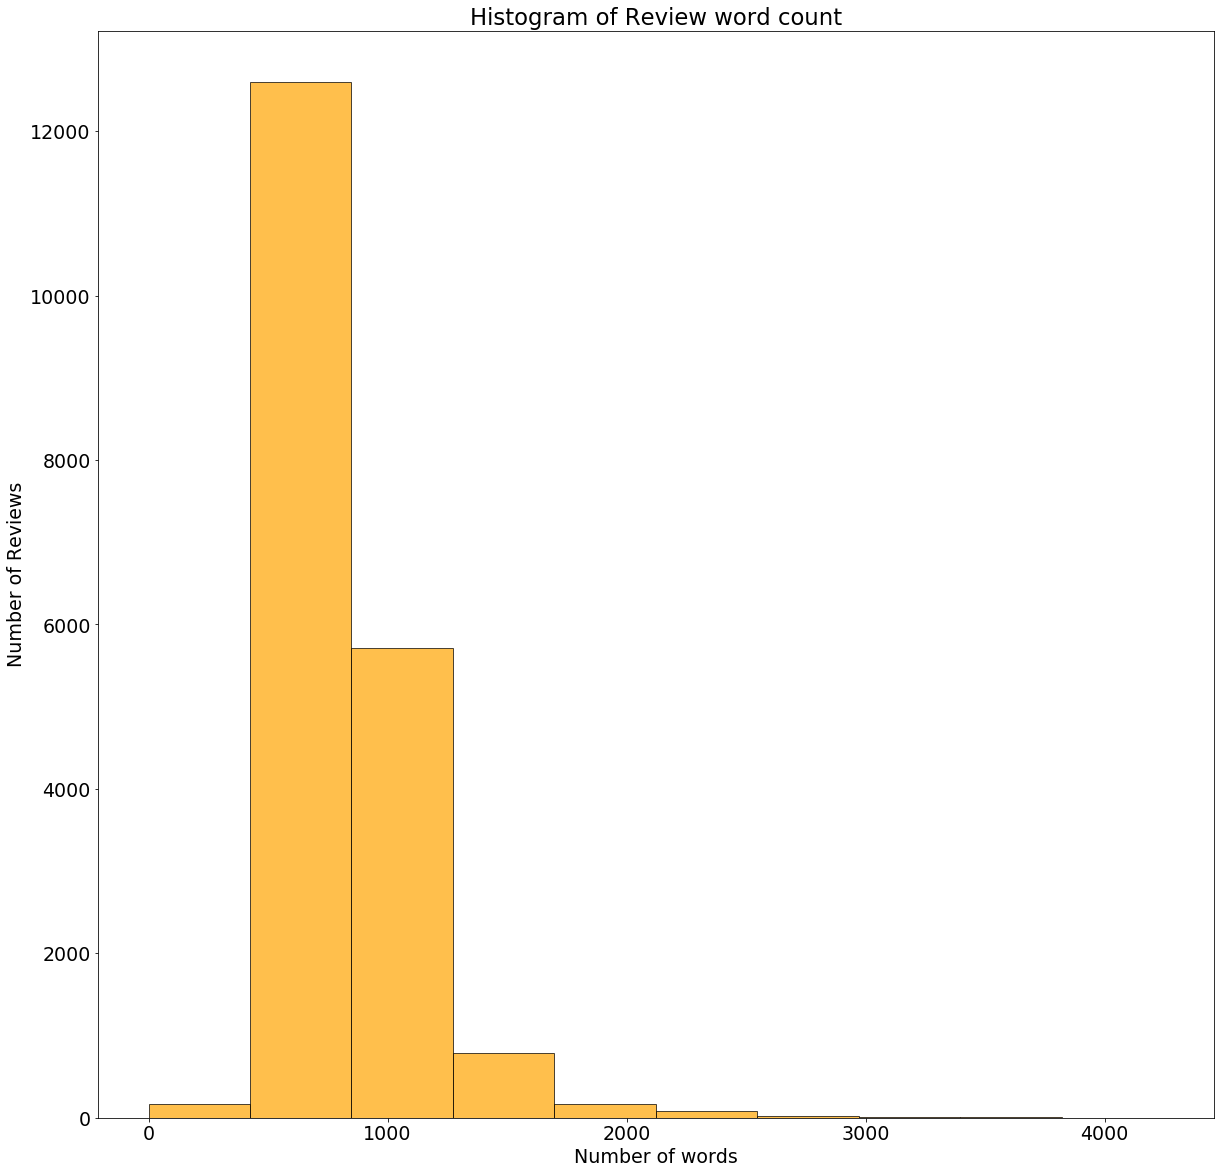

In [27]:
# Distribution of word count for reviews
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 19})
plt.hist(data['review_word_count'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Histogram of Review word count")
plt.xlabel("Number of words")
plt.ylabel("Number of Reviews")
plt.show()

## Average Score for Genre
Another factor we decided to explore and visualize was the average review score by genre. We did this to see if there was a genre of music that tended to be reviewed significantly higher than other genres, which could indicate a bias or preference for this genre of music. After further exploration, it appears that electronic, metal, none, pop/r&b, rap, and rock genres all receive, on average, about the same score. Jazz, experimental, folk/country, and global genres appear to have slightly higher review scores than the rest of the genres. This could potentially indicate a preference by the magazine for these four genres, which is something that we need to keep in mind moving forward with our analysis.

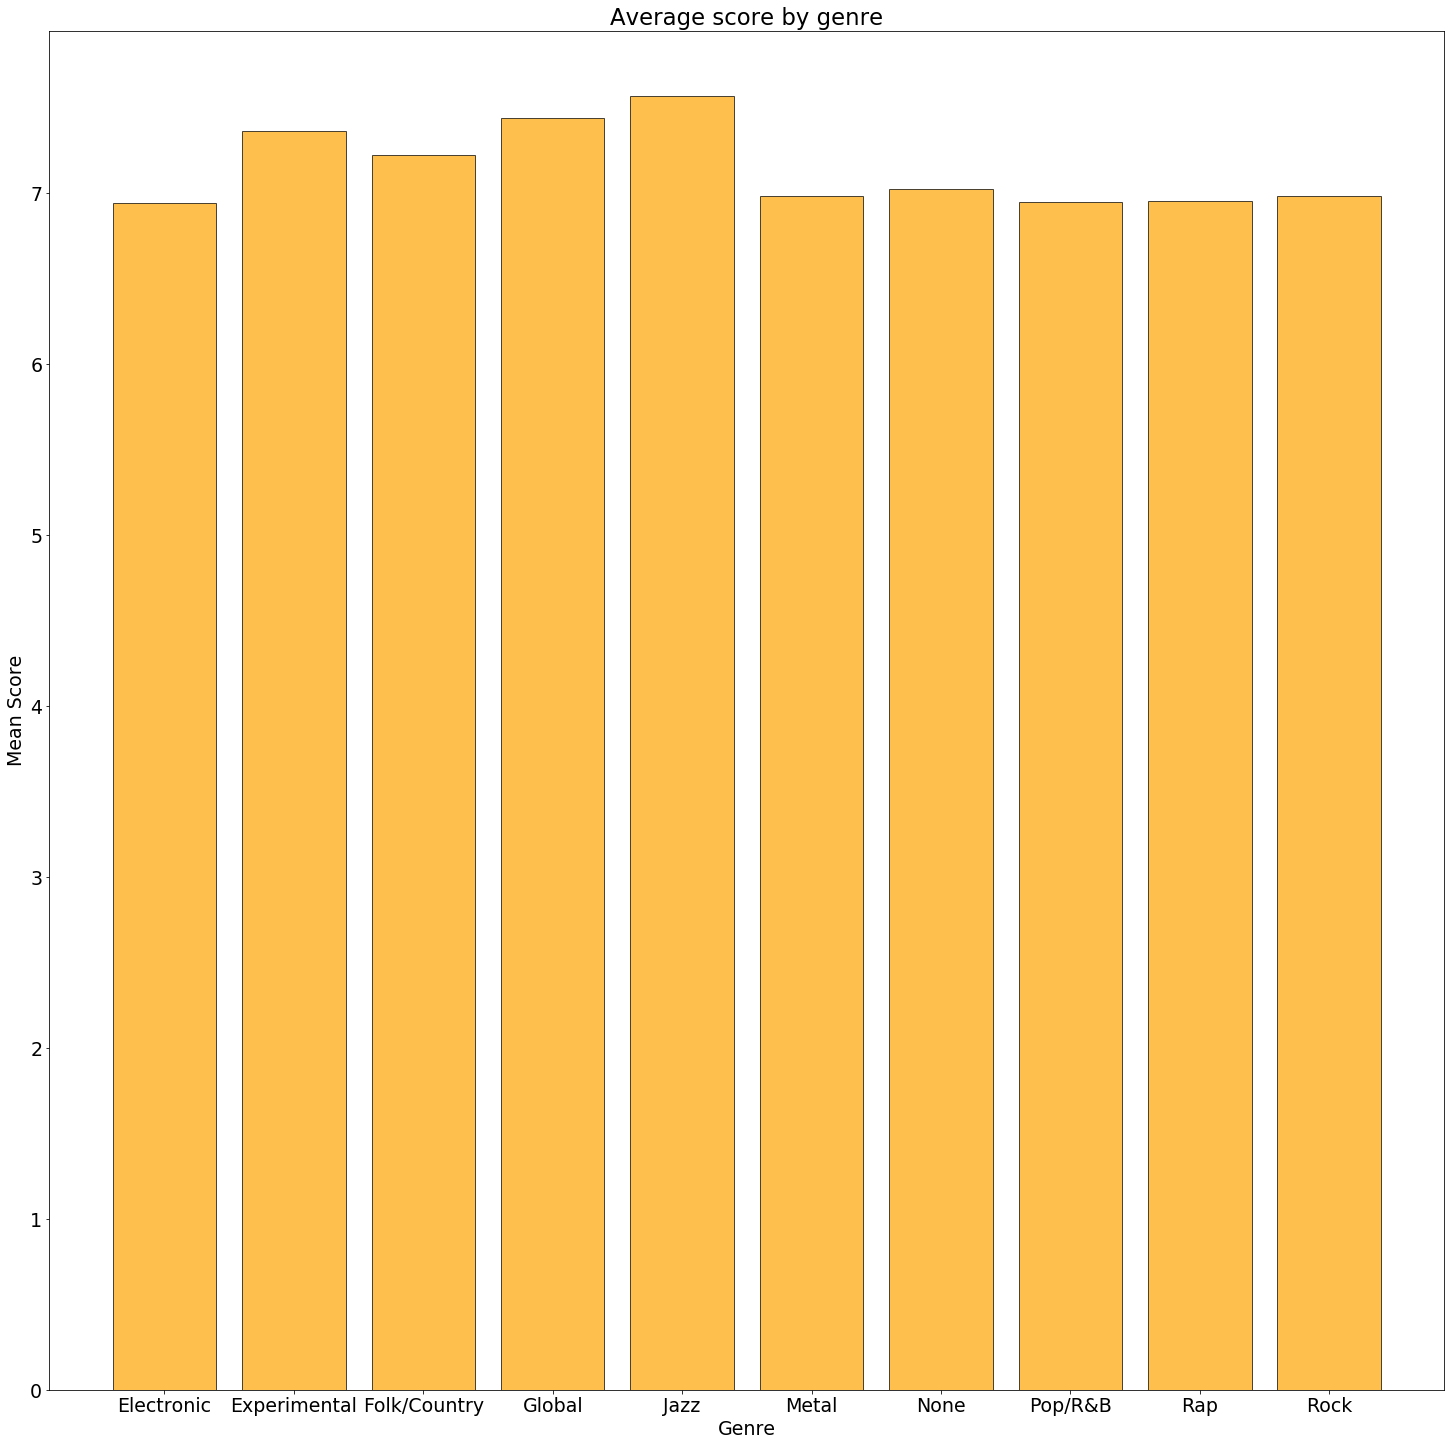

In [65]:
# Average score for each genre
plt.figure(figsize=(25, 25))
plt.rcParams.update({'font.size': 19})
plt.bar(groupped_by_genre.index, groupped_by_genre['score'], color='orange', alpha=0.7, edgecolor='black')
plt.title("Average score by genre")
plt.xlabel("Genre")
plt.ylabel("Mean Score")
plt.show()

## Mean Score By Genre By Year
At this point, we chose to perform a more in depth exploration. We started by looking at the mean score of each genre for each year. We chose to explore/visualize this to understand trends in rating. For example: is there one genre that has consistently been getting the same scores overtime, is there a genre that has seen a decline in scores overtime, is there a genre that has seen an increase in scores overtime? After exploring this topic, we see that there was initially a much larger spread in the mean scores by genre. Over time, however, the mean scores by genre have gotten closer together in terms of spread. Something that stood out to us was how high of an average rating the Global Genre was in 1999. This prompted us to research the number of reviews by year per genre, which revealed to us that there was a very small number of reviews for Global Genre that year, which could have played a role in the average rating being so high. From this visualization, we learned more about the mean scores by genre and how they changed over time.

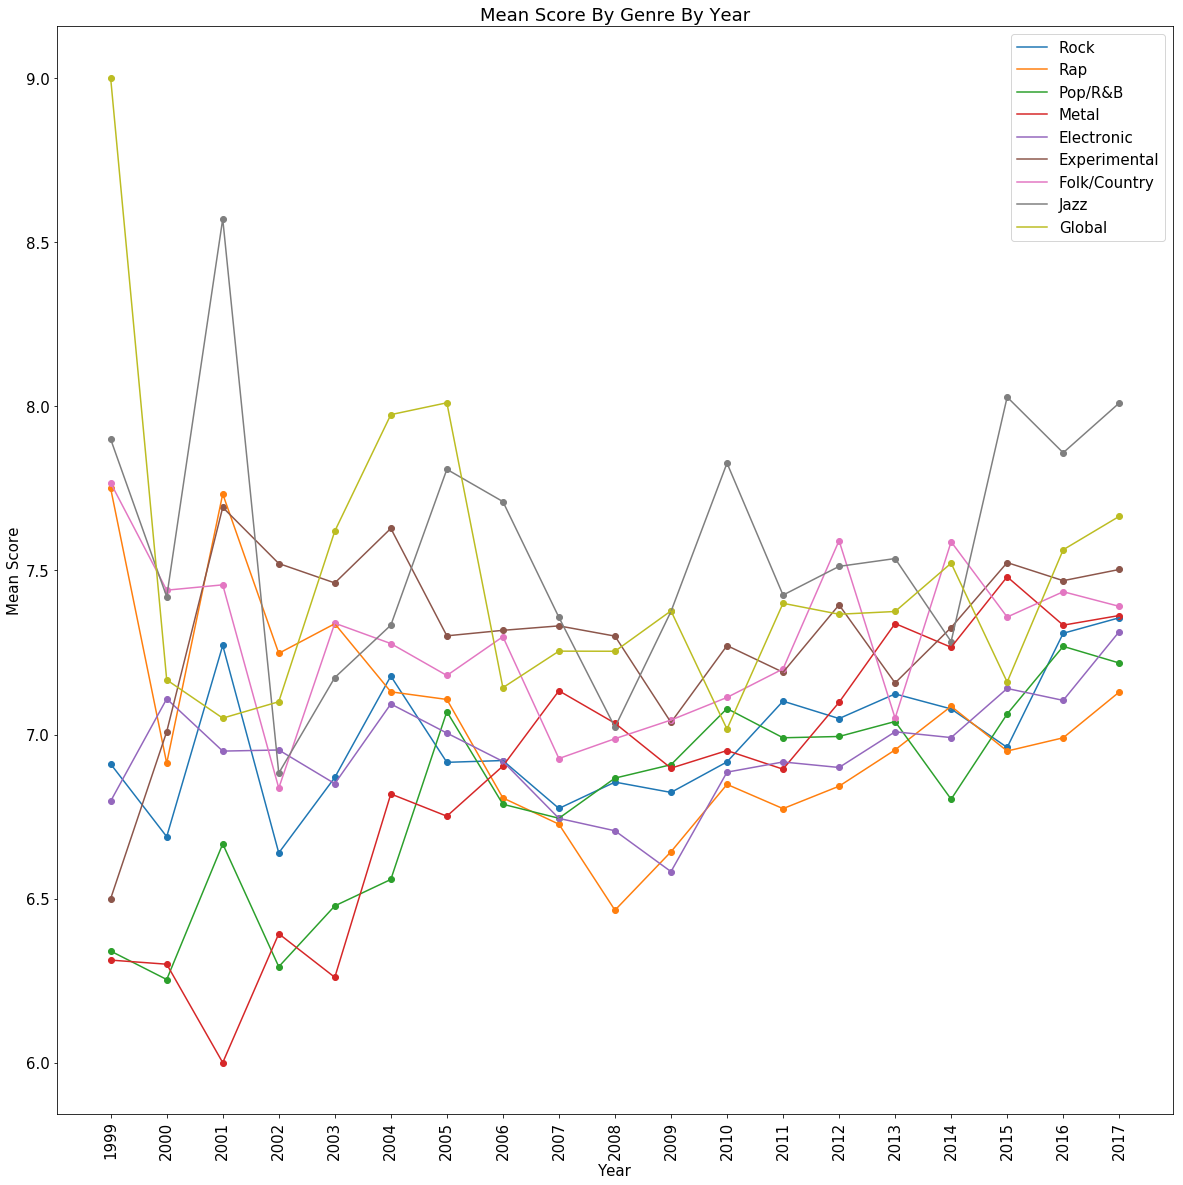

In [64]:
# Mean score by genre by year
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
for genre in data['genre'].unique():
    if genre != 'None':
        genres = data.loc[data['genre'] == genre]
        genres = genres.groupby(data['date'].dt.year).aggregate('mean')
        ax.scatter(genres.index, genres['score'], label=None)
        ax.plot(genres.index, genres['score'], label=genre)
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Mean Score")
plt.xticks(x_labels)
plt.title("Mean Score By Genre By Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

## Number of Reviews By Genre Over Time
After seeing our results from exploring the mean score by genre by year, we wanted to be able to better understand our potential outliers. To do this, we supplemented this exploration by looking at the number of reviews by genre over time. We chose to do this in order to understand if there was a large number or a small number of albums reviewed that year, and then compared the number of reviews by genre to the mean review score by genre for each year. We also explore how what genres Pitchfork chooses to review has changed, if at all, over time. Our exploration and data visualization revealed a couple of notable things. First, the Global Genre and the Jazz Genre is pretty consistently the least reviewed genre over time. Second, the Rock Genre is the genre that is always the most reviewed no matter what year it is. This could indicate a preference for this genre of music, which could lead to a bias in review scores for rock music.

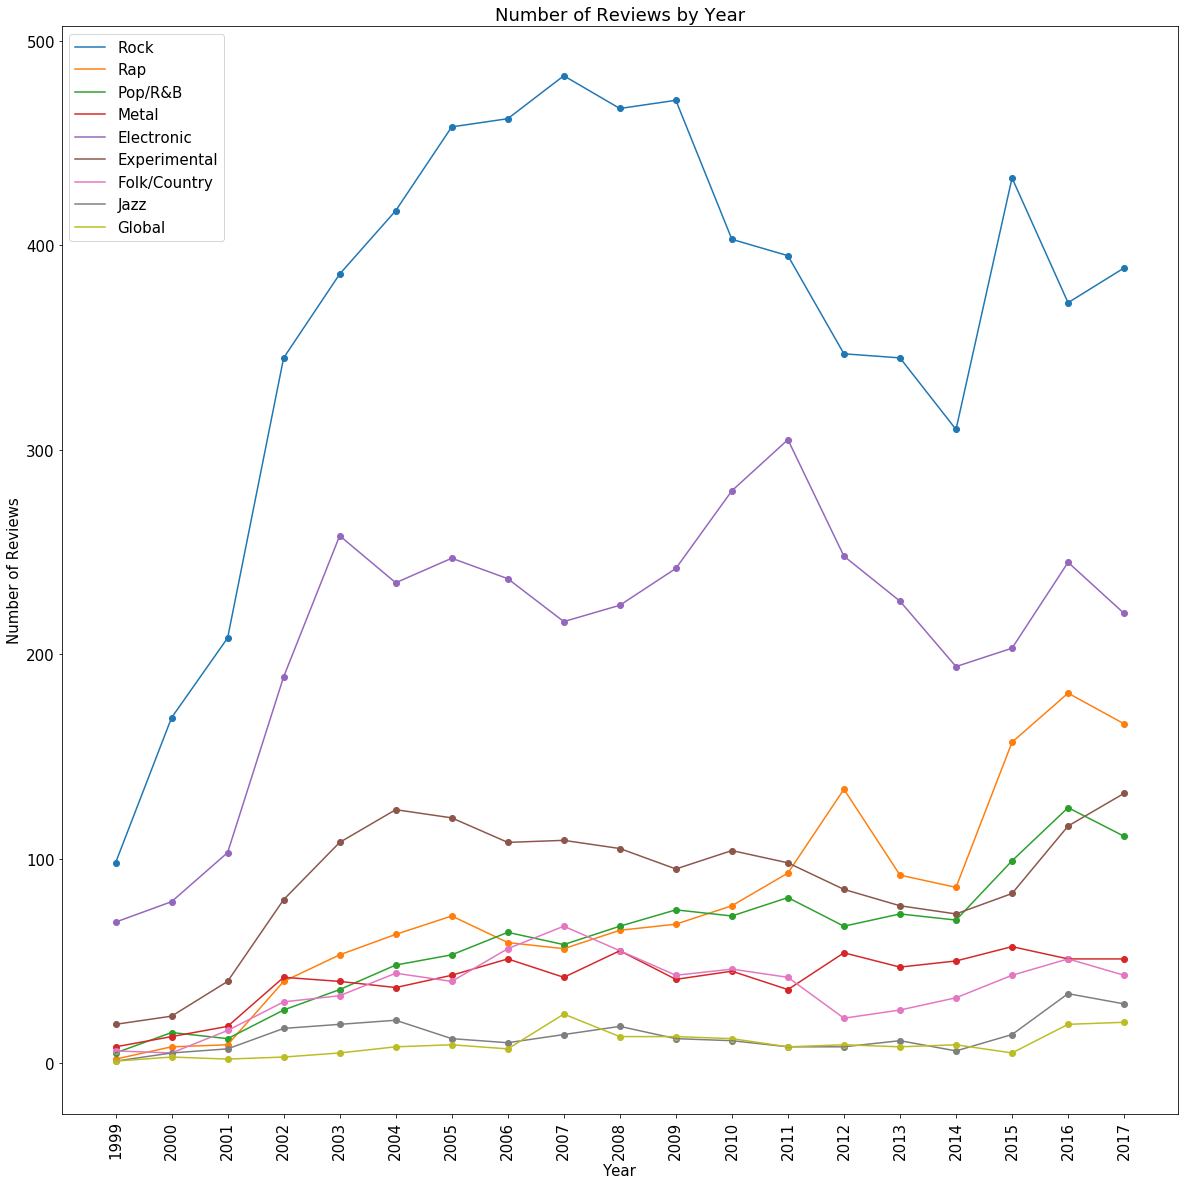

In [30]:
# Number of albums per genre over time
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
for genre in data['genre'].unique():
    if genre != 'None':
        genres = data.loc[data['genre'] == genre]
        genres = genres.groupby(data['date'].dt.year).aggregate('count')
        ax.scatter(genres.index, genres['score'], label=None)
        ax.plot(genres.index, genres['score'], label=genre)
    
x_labels = range(1999,2018,1)
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(x_labels)
plt.title("Number of Reviews by Year")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()

# Analysis

### Is there a relationship between best new music and a function of score and genre?

In [31]:
#Let's see if we can find any statistically significant relationships using linear modeling
mod = smf.ols(formula= 'best ~ score + genre', data=data)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   best   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     213.1
Date:                Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:01:32   Log-Likelihood:                 2486.1
No. Observations:               19555   AIC:                            -4950.
Df Residuals:                   19544   BIC:                            -4864.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3278      0.009    -36.488      0.000      -0.345      -0.310
genre[T.Experimental]    -0.0053      0.006     -0.855      0.392      -0.017       0.007
genre[T.Folk/Country]    -0.0159      0.009     -1.826      0.068      -0.033       0.001
genre[T.Global]          -0.0242      0.016     -1.479      0.139      -0.056       0.008
genre[T.Jazz]             0.0153      0.014      1.115      0.265      -0.012       0.042
genre[T.Metal]           -0.0220      0.008     -2.634      0.008      -0.038      -0.006
genre[T.None]            -0.0286      0.006     -5.155      0.000      -0.040      -0.018
genre[T.Pop/R&B]          0.0268      0.007      3.770      0.000       0.013       0.041
genre[T.Rap]              0.0069      0.006      1.061      0.289      -0.006       0.020
genre[T.Rock]             0.0105      0.004      2.485      0.013       0.002       0.019
score                     0.0541      0.001     45.109      0.000       0.052       0.056
==============================================================================
Omnibus:                    13456.538   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133561.087
Skew:                           3.396   Prob(JB):                         0.00
Kurtosis:                      13.854   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our R-squared value is extremely low, so our model shouldn't be used to make conclusions about the relationship between genre, score, and best new music.   Furthermore, it may be the case that score and genre are not good explanatory variables for best new music.  

### Who are the most consistenly good (and bad) artists within the top 100 reviewed?

First, let's sort based off how often the Artist was reviewed:

In [56]:
top_100_artists = reviews_no_various_artists.groupby(['artist']).size().sort_values(ascending=False)
top_100_artists = top_100_artists.head(n=100)
top_100_artists

artist
Guided by Voices                                25
David Bowie                                     22
The Beatles                                     21
Mogwai                                          21
Of Montreal                                     20
The Fall                                        20
Animal Collective                               19
Neil Young                                      19
Robert Pollard                                  19
Bob Dylan                                       18
Xiu Xiu                                         18
R.E.M.                                          17
Sonic Youth                                     16
Gucci Mane                                      16
Four Tet                                        16
Bonnie Prince Billy                           16
Deerhoof                                        16
Lil Wayne                                       15
The Flaming Lips                                15
Nine Inch Nails         

Calculate statistics for the top 100 artists such as their average score, their worst score, their best score, and the standard deviation of the scores.  We can then sort these calculations by average score to see the highest rated artist, which is The Beatles

In [63]:
artist_score = pd.DataFrame(columns=['artist', 'avg_score', 'best_score', 'std'])
for artist, count in top_100_artists.items():
    artist_reviews = data[data['artist'] == artist]
    avg_score = artist_reviews['score'].mean()
    best_score = artist_reviews['score'].max()
    worst_score = artist_reviews['score'].min()
    std = artist_reviews['score'].std()
    artist_score = artist_score.append({'artist': artist, 'avg_score': avg_score, 'best_score': best_score, 'worst_score': worst_score,'std': std}, ignore_index=True)

artist_score = artist_score.sort_values(by=["avg_score"], ascending = False)
artist_score

,artist,avg_score,best_score,std,worst_score
2,The Beatles,8.890476,10.0,1.314117,6.0
35,Miles Davis,8.730769,9.5,0.833051,6.6
64,Califone,8.308333,9.2,0.462126,7.3
25,Radiohead,8.071429,10.0,1.930496,4.0
61,Tim Hecker,8.066667,8.7,0.539921,6.8
55,William Basinski,8.041667,10.0,0.954852,7.0
36,Saint Etienne,8.015385,9.0,0.757018,6.4
44,Mouse on Mars,7.950000,9.6,0.783349,7.0
11,R.E.M.,7.947059,10.0,1.603947,5.0
56,Arthur Russell,7.883333,8.9,0.676667,6.5


### What is the relationship between review word count and score?

In [34]:
word_count_mod = smf.ols(formula= 'review_word_count ~ score', data=data).fit()
word_count_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      review_word_count   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1138.
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          1.60e-242
Time:                        12:01:33   Log-Likelihood:            -1.3789e+05
No. Observations:               19555   AIC:                         2.758e+05
Df Residuals:                   19553   BIC:                         2.758e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    442.3425     11.170     39.603      0.000     420.449     464.236
score         52.7524      1.564     33.734      0.000      49.687      55.818
==============================================================================
Omnibus:                    10617.184   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           131560.622
Skew:                           2.352   Prob(JB):                         0.00
Kurtosis:                      14.805   Cond. No.                         40.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
data['word_count_preds'] = word_count_mod.predict()
data

,album,artist,best,date,genre,review,score,score_of_100,review_word_count,word_count_preds
1,A.M./Being There,Wilco,1,2017-12-06,Rock,Best new reissue 1 / 2 Albums Newly reissued a...,7.0,70,1820,811.609092
2,No Shame,Hopsin,0,2017-12-06,Rap,"On his corrosive fifth album, the rapper takes...",3.5,35,1107,626.975796
3,Material Control,Glassjaw,0,2017-12-06,Rock,"On their first album in 15 years, the Long Isl...",6.6,66,1145,790.508144
4,Weighing of the Heart,Nabihah Iqbal,0,2017-12-06,Pop/R&B,"On her debut LP, British producer Nabihah Iqba...",7.7,77,931,848.535752
5,The Visitor,Neil Young / Promise of the Real,0,2017-12-05,Rock,"While still pointedly political, Neil Youngs ...",6.7,67,788,795.783381
6,Perfect Angel,Minnie Riperton,1,2017-12-05,Pop/R&B,Best new reissue A deluxe reissue of Minnie Ri...,9.0,90,1485,917.113833
7,Everyday Is Christmas,Sia,0,2017-12-05,Pop/R&B,Sias shiny Christmas album feels inconsistent...,5.8,58,748,748.306248
8,Zaytown Sorority Class of 2017,Zaytoven,0,2017-12-05,Rap,The prolific Atlanta producer enlists 17 women...,6.2,62,919,769.407196
9,Songs of Experience,U2,0,2017-12-04,Rock,"Years in the making, U2s 14th studio album fi...",5.3,53,1294,721.930063
10,Post Self,Godflesh,0,2017-12-04,Metal,The new LP from pioneering industrial band God...,8.1,81,636,869.636700


Based off the predictions from our linear model, we can see that either a) this model doesn't predict word count well or b) score is not a good indicator of word count.  We can confirm this by looking at R-squared of the summary, where it is extremely low. 

# Conclusion
When we began our exploration and analysis, we had the following questions:
- How do reviews for genres change over time?
- Is there a correlation between an album's score and it being in Pitchfork's Best New Music?
    - Is there a correlation between genre and review score?
    - Is there a correlation between genre and selection for Best New Music?
- How do the most reviewed artists vary in score--who are the most consistent, the best, and the worst?
- Is there a relationship between the review word length (potentially a stand in for how much a reviewer dedicated to a particular review) and score?

We started our exploration by looking at the overall mean review score, which we found to be 7.027 out of 10. Grouping reviews by genre, we found the mean review score for each genre; electronic music was 6.941, experimental music was 7.359, folk/country music was 7.220, global music was 7.435, jazz music was 7.569, metal music was 6.980, non-categorized music was 7.020, pop/R&B music was 6.950, rap was 6.950, and rock was 6.984.  Electronic, Metal, None (non-categorized), Pop/R&B, Rap and Rock were genres that had an average review score under the general average review score. Experimental, Folk/Country, Global, and Jazz were genres that had an average review score above the general review score. However, these values do not reflect the volume of reviews per genre so we chose to also examine the number of reviews for each genre. We found that jazz music, which has the highest average review score, has only 257 reviews. This is extremely small compared to other categories. This genre had the second lowest number of reviews, and the could have inadvertently factored into giving it a higher average score. Comparatively, electronic music, which has the lowest average review score, has 4020 reviews. This genre has the second highest number of reviews, and the fact that there were so many reviews could have inadvertently factored into giving it a lower average score.

The next thing we chose to look at was the ratios of the amount of reviews that are in best new music compared to total reviews, broken down by genre. In other words, for each genre, we have calculated the percentage of reviews that were chosen for Best New Music. We found that jazz music had the highest percentage of 9.727% and none (not categorized genre) had the worst percentage of 2.387%  This indicated that Pitchfork may have a preference or bias for jazz music, and be more likely to choose jazz music for Best New Music over other genres.

The first thing we chose to visualize was the number of reviews per year. We found that from 1999 to 2003, Pitchfork experienced growth in the number of reviews released per year. From 2004 onward, the number of reviews released by Pitchfork has remained relatively constant. This gave us a better understanding of the growth of the magazine overtime, as well as an understanding of possible discrepancies that might appear when we look at review scores by genre since earlier years have a much smaller volume of reviews than later years.

Next we visualized the number of reviews per genre. While we had already performed this exploration earlier, we thought it might be helpful to visualize these numbers by creating a histogram. We found that the most frequently reviewed genre by far was Rock music, which could indicate a potential preference or bias for this music genre by Pitchfork, which could lead to bias reviews and review scores.

Next, we explored the distribution of review scores. From this exploration, we see a right-shift in our data. This shows us that Pitchfork is more likely to give a higher score than a lower score. We also found that the data peaks around 7, so about 7 is would be the mode of the data set. This aligns with the mean (7.027) that we had previously found.

Something we thought would be interested to explore would be the word count of reviews. We found that the most common review length was between ~400-800 words. We also found that there were a couple of outlier articles that had a word count ranging from ~2500 to 3800, and these outliers have the potential to skew any model we create in relation to word count.

We began to do more in depth explorations with data visualization, and look at the mean score of each genre for each year. We found that there was initially a much larger spread in the mean scores by genre. Over time, however, the mean scores by genre have gotten closer together in terms of spread. Something that stood out to us was how high of an average rating the Global Genre was in 1999. This prompted us to research the number of reviews by year per genre, which revealed to us that there was a very small number of reviews for Global Genre that year, which could have played a role in the average rating being so high. From this visualization, we learned more about the mean scores by genre and how they changed over time.

Since our previous visualization does not reflect the number of reviews, we supplemented this exploration by looking at the number of reviews by genre over time to better understand potential outliers and possible biases. Our exploration and data visualization revealed a couple of notable things. First, the global Genre and the jazz Genre are pretty consistently the least reviewed genre over time. Second, the rock Genre is the genre that is always the most reviewed no matter what year it is. This could indicate a preference for this genre of music, which could lead to a bias in review scores for rock music.

After our initial exploration and data visualizations, we began to create models to help us answer our research questions.

First, we sought to answer our second main question about the relationship between genre, score, and best new music. We used a simple linear regression to assess this relationship (we decided due to the lack of features that machine learning or other approaches didn't make much sense).  Soewhat unfortunately, the model didn't fit the data particuarly well with a surprisingly low R-squared value of 0.098.  This could very well be because score and genre are not good predictors of best new music, although we cannot declare this conclusively.  All that said Jazz, Pop/R&B, Rap, and Rock were genres which our model said had a positive association with a "Best New Music" ranking.


Afterwards, we wanted to do an exploration of the top 100 most-reviewed artists to see which artists Pitchfork thought were the best and which were the worst.  This also gave us insight into how much album scores vary for a particular knowledge.  However, this only applies to the top 100 most-reviewed, and not all artists, so it is not universally telling. We chose the top 100 just so we would have more data to work with.  From this exploration, we were able to conclude that The Beatles were the highest rated artist of the most reviewed artists with an average score of 8.8/10 and the worst was Weezer with an average of 5.5/10. Interestingly, Weezer was also the artist with the most variance in the scores with a standard deviation of 2.7--this is somewhat obvious when looking at their best score, a perfect 10/10, and their worst score, a sad 0.4/10.  

Finally, we sought to evaluate the relationship between review word count and score.  Again, we chose to use a linear regression. And again, we found that our model did not fit the data particuarly well with an R-squared value of 0.055.  Potential reasons why this might be are i) poor model selection ii) word count not having a relationship with score--maybe instead being dependent on who wrote the review, how long the album is, etc.

Overall, this was a helpful investigation into exploring Pitchfork's dataset.  More than anything else, we think that viewing how scores for a genre vary over time and how much Pitchfork "likes/dislikes" particular artists will aide in the contextual understanding of Pitchfork reviews.